In [23]:
import pandas as pd
import numpy as np
import math
import time
import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)
import matplotlib.pyplot as plt

Runnning Cantera version: 3.0.0


In [24]:
gas = ct.Solution('Jerzembeck.yaml')
rad = 0.037
Area = 4* 3.14 * (rad**2)
vol = 4/3 * 3.14 *(rad**3)
print (Area)
print (vol)

0.017194639999999997
0.0002120672266666666


In [25]:
# Define the reactor temperature and pressure
reactor_temperature = 800  # Kelvin
reactor_pressure = 101325  # Pascals
    
gas.TP = reactor_temperature, reactor_pressure
    
# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel="IXC8H18", oxidizer={"o2": 1.0, "n2": 3.76})
    
# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])
    
# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")
    

    

In [26]:
def ignition_delay(states, species):
        """
        This function computes the ignition delay from the occurence of the
        peak in species' concentration.
        """
        i_ign = states(species).Y.argmax()
        return states.t[i_ign]

In [27]:
reference_species = "oh"
    
# Tic
t0 = time.time()
    
# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 20
t = 0
counter = 1
while t < estimated_ignition_delay_time :
    t = reactor_network.step()
    if not counter % 10:
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
    counter += 1
# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)
    
# Toc
t1 = time.time()
    
print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")
    
# If you want to save all the data - molefractions, temperature, pressure, etc
    # >>>>>>>>>>>>>>>>>>>>>>>>uncomment the next line
    

#plt.xlim([0,0.1])



Computed Ignition Delay: 2.845e+00 seconds. Took 2.19s to compute


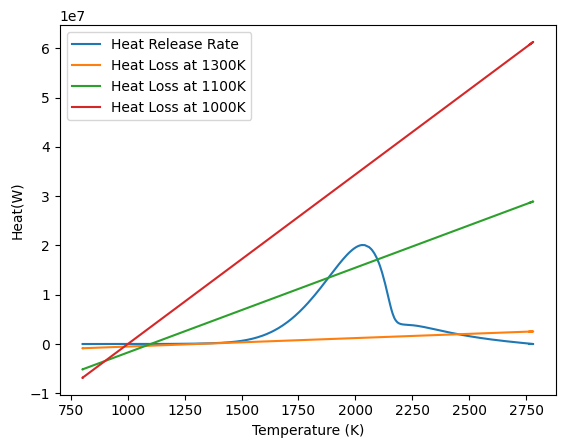

In [28]:
q_lost_1 = []
q_lost_2 = []
q_lost_3 = []
for T in time_history.T :
    
    q_lost_11 = Area * (T-1300) * (0.1*1e+06)
    q_lost_22 = Area * (T-1100) * (1*1e+06)
    q_lost_33 = Area * (T-1000) * (2*1e+06)

    q_lost_1.append(q_lost_11)
    q_lost_2.append(q_lost_22)
    q_lost_3.append(q_lost_33)

HRT = []

for q_r in time_history.heat_release_rate :
    q_rw = q_r * vol 
    HRT.append(q_rw)


plt.plot(time_history.T,HRT, label = "Heat Release Rate")
plt.plot(time_history.T,q_lost_1,label= "Heat Loss at 1300K")
plt.plot(time_history.T,q_lost_2, label = "Heat Loss at 1100K")
plt.plot(time_history.T,q_lost_3, label = "Heat Loss at 1000K")
plt.xlabel("Temperature (K)")
plt.ylabel("Heat(W)")
plt.legend()
plt.show()
